In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif",
})

In [2]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

xlabel_kwargs = {"fontsize":15}
ylabel_kwargs = {"fontsize":15}
legend_kwargs = {"fontsize":12}
title_kwargs = {"fontsize":18}

In [3]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [4]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [5]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_cdv


In [6]:
from tools.ae_v1 import Autoencoder

In [7]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-08-06 16:52:04.176881: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-06 16:52:04.230342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-06 16:52:04.230544: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-06 16:52:04.231715: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [8]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# Kolmogorov Flow System

In [9]:
prng_seed = 42
np.random.seed(prng_seed)

train_split = 0.8
val_split = 0.1
test_split = 0.1

In [10]:
ae_idx = '010'
dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
print(dir_name_ae)

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
ae_module = params_dict['module']
try:
    use_ae_data = params_rnn_dict['use_ae_data']
except:
    print("'use_ae_data' not present in RNN_specific_data, set to True.")
    use_ae_data = True
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx

with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data_og = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

num_params = params_mat.shape[1]
og_vars = all_data_og.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

/home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_010
'use_ae_data' not present in RNN_specific_data, set to True.
data_dir_idx: 005
normalize_flag_ogdata: False


In [11]:
if ae_data_with_params == False:
    all_data_og = all_data_og[:, 0:og_vars]
    normalization_constant_arr_aedata = normalization_constant_arr_aedata[:, 0:og_vars]

In [12]:
print(all_data_og.shape)

(400002, 12)


In [13]:
cum_samples = boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train += int( np.round(train_split*num_samples) )
    num_val += int( np.round(val_split*num_samples) )
    begin_idx = boundary_idx_arr[i]

# defining shapes
training_shape = [num_train]
training_shape.extend(all_data_og.shape[1:])

val_shape = [num_val]
val_shape.extend(all_data_og.shape[1:])

testing_shape = [cum_samples-num_train-num_val]
testing_shape.extend(all_data_og.shape[1:])

# defining required arrays
training_data = np.empty(shape=training_shape)

val_data = np.empty(shape=val_shape)

testing_data = np.empty(shape=testing_shape)

boundary_idx_arr_testing = np.empty_like(boundary_idx_arr)
boundary_idx_arr_training = np.empty_like(boundary_idx_arr)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train = int( np.round(train_split*num_samples) )
    num_val = int( np.round(val_split*num_samples) )

    training_data[training_data_rolling_count:training_data_rolling_count+num_train] = all_data_og[begin_idx:begin_idx+num_train]
    training_data_rolling_count += num_train
    boundary_idx_arr_training[i] = training_data_rolling_count

    val_data[val_data_rolling_count:val_data_rolling_count+num_val] = all_data_og[begin_idx+num_train:begin_idx+num_train+num_val]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val
    testing_data[testing_data_rolling_count:testing_data_rolling_count+num_test] = all_data_og[begin_idx+num_train+num_val:begin_idx+num_train+num_val+num_test]
    testing_data_rolling_count += num_test
    boundary_idx_arr_testing[i] = testing_data_rolling_count

    begin_idx = boundary_idx_arr[i]

# further shuffling
# idx = np.arange(0, training_data.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
np.random.shuffle(training_data)

# idx = np.arange(0, val_data.shape[0])
# np.random.shuffle(idx)
# val_data = val_data[idx]
# np.random.shuffle(val_data)

# idx = np.arange(0, testing_data.shape[0])
# np.random.shuffle(idx)
# testing_data = testing_data[idx]
# np.random.shuffle(testing_data)

In [14]:
print('training_data.shape : ', training_data.shape)
print('val_data.shape : ', val_data.shape)
print('testing_data.shape : ', testing_data.shape)
print('og_vars : ', og_vars)

training_data.shape :  (320002, 12)
val_data.shape :  (40000, 12)
testing_data.shape :  (40000, 12)
og_vars :  6


In [15]:
if normalizeforae_flag == True:
    training_data -= normalization_constant_arr_aedata[0]
    training_data /= normalization_constant_arr_aedata[1]

    testing_data -= normalization_constant_arr_aedata[0]
    testing_data /= normalization_constant_arr_aedata[1]

In [16]:
load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

ae_net = Autoencoder(data_dim=training_data.shape[1], load_file=load_file)
ae_net.load_weights_from_file(wt_file)

In [17]:
latent_states_all_trainingdata = np.array(ae_net.encoder_net.predict(training_data))
latent_states_all_testingdata = np.array(ae_net.encoder_net.predict(testing_data))

reconstructed_data_trainingdata = ae_net.decoder_net.predict(latent_states_all_trainingdata)
reconstructed_data_testingdata = ae_net.decoder_net.predict(latent_states_all_testingdata)

In [23]:
individual_NRMSE_test = np.empty(shape=len(boundary_idx_arr_testing))

begin_train = 0
begin_test = 0

ogog_vars = og_vars
# og_vars = training_data.shape[1]

for i in range(len(boundary_idx_arr_testing)):
    end_train = boundary_idx_arr_training[i]
    end_test = boundary_idx_arr_testing[i]
    
    stddev = np.std(training_data[begin_train:end_train, 0:og_vars], axis=0)
    stddev[ogog_vars:] = 1.
    
    individual_NRMSE_test[i] = np.mean(np.mean((testing_data[begin_test:end_test, 0:og_vars]-reconstructed_data_testingdata[begin_test:end_test, 0:og_vars])**2/stddev**2, axis=1)**0.5, axis=0)
    
    begin_train = boundary_idx_arr_training[i]
    begin_test = boundary_idx_arr_testing[i]

og_vars = ogog_vars

In [24]:
individual_NRMSE_test

array([0.01438436, 0.01228275])

In [25]:
np.savez(
    dir_name_ae+'/plots/individual_NRMSE_test',
    individual_NRMSE_test=individual_NRMSE_test,
)

In [26]:
with open(dir_name_ae+'/plots/individual_NRMSE_test.txt', 'w') as f:
    s = ', '.join(['{:.2E}'.format(elem) for elem in individual_NRMSE_test])
    f.write(s)

In [19]:
# del(training_data)
del(val_data)
# del(testing_data)

In [19]:
ls_shape = latent_states_all_testingdata.shape[1:]
og_shape = training_data.shape[1:]

In [20]:
print('ls_shape : ', ls_shape)
print('og_shape : ', og_shape)

ls_shape :  (5,)
og_shape :  (12,)


In [21]:
print('latent_states_all_trainingdata.shape : {}'.format(latent_states_all_trainingdata.shape))
print('latent_states_all_testingdata.shape : {}\n'.format(latent_states_all_testingdata.shape))

# print('reconstructed_data_trainingdata.shape : {}'.format(reconstructed_data_trainingdata.shape))
# print('reconstructed_data_testingdata.shape : {}'.format(reconstructed_data_testingdata.shape))

latent_states_all_trainingdata.shape : (320002, 5)
latent_states_all_testingdata.shape : (40000, 5)



In [22]:
if normalizeforae_flag == True:
    # reconstructed_data_trainingdata *= normalization_constant_arr_aedata[1]
    # reconstructed_data_trainingdata += normalization_constant_arr_aedata[0]
    training_data *= normalization_constant_arr_aedata[1]
    training_data += normalization_constant_arr_aedata[0]

    # reconstructed_data_testingdata *= normalization_constant_arr_aedata[1]
    # reconstructed_data_testingdata += normalization_constant_arr_aedata[0]
    testing_data *= normalization_constant_arr_aedata[1]
    testing_data += normalization_constant_arr_aedata[0]

In [23]:
# POD in latent space
latent_states_all_trainingdata = np.reshape(latent_states_all_trainingdata, (latent_states_all_trainingdata.shape[0], -1))
mean_ls = np.mean(latent_states_all_trainingdata, axis=0)
meancentered_ls = latent_states_all_trainingdata - mean_ls
covmat_ls = np.matmul(meancentered_ls.transpose(), meancentered_ls) / (meancentered_ls.shape[0] - 1)

eigenvals_ls, eigenvecs_ls = linalg.eig(covmat_ls)
eigenvals_ls = np.abs(eigenvals_ls)
sorted_idx = np.argsort(eigenvals_ls)
eigenvals_ls = eigenvals_ls[sorted_idx]
eigenvecs_ls = eigenvecs_ls[:, sorted_idx]

del(covmat_ls)

In [24]:
eigenvecs_ls.shape, eigenvals_ls

((5, 5), array([0.00902993, 0.01704936, 0.03399722, 0.0792623 , 0.41382223]))

In [25]:
# POD in actual-data space
training_data = np.reshape(training_data, (training_data.shape[0], -1))
mean_og = np.mean(training_data, axis=0)
meancentered_og = training_data - mean_og
covmat_og = np.matmul(meancentered_og.transpose(), meancentered_og) / (meancentered_og.shape[0] - 1)

eigenvals_og, eigenvecs_og = linalg.eig(covmat_og)
eigenvals_og = np.abs(eigenvals_og)
sorted_idx = np.argsort(eigenvals_og)
eigenvals_og = eigenvals_og[sorted_idx]
eigenvecs_og = eigenvecs_og[:, sorted_idx]

del(covmat_og)

In [26]:
testing_data_PODcomps = testing_data @ eigenvecs_og[:, :]
ls_testing_data_PODcomps = latent_states_all_testingdata @ eigenvecs_ls[:, :]

In [27]:
# %matplotlib widget

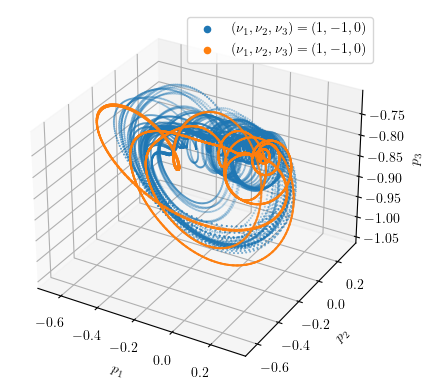

In [28]:
fig = plt.figure()
ax = fig.add_subplot(
    projection='3d'
)
# ax.view_init(
#     elev=30,
#     azim=-60,
# #     roll=15,
# )

begin_idx = 0
idx1 = -1
idx2 = -2
idx3 = -3
for i in range(len(boundary_idx_arr_testing)):
    end_idx = boundary_idx_arr_testing[i]
    ax.scatter(
        testing_data_PODcomps[begin_idx:end_idx, idx1].transpose(),
        testing_data_PODcomps[begin_idx:end_idx, idx2].transpose(),
        testing_data_PODcomps[begin_idx:end_idx, idx3].transpose(),
        label=r"$(\nu_1, \nu_2, \nu_3) = ("+'{:.0f}, {:.0f}, {:.0f}'.format(*params_mat[i])+r')$',
        s=0.2
    )
    begin_idx = boundary_idx_arr_testing[i]

ax.set_xlabel(r'$p_'+str(-idx1)+r'$')
ax.set_ylabel(r'$p_'+str(-idx2)+r'$')
ax.set_zlabel(r'$p_'+str(-idx3)+r'$')

plt.legend(markerscale=10)
plt.grid(True)

plt.show()
plt.close()

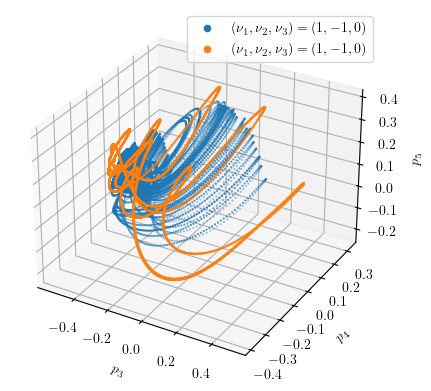

In [29]:
fig = plt.figure()
ax = fig.add_subplot(
    projection='3d'
)
# ax.view_init(
#     elev=30,
#     azim=-60,
# #     roll=15,
# )

begin_idx = 0
idx1 = -3
idx2 = -4
idx3 = -5
for i in range(len(boundary_idx_arr_testing)):
    end_idx = boundary_idx_arr_testing[i]
    ax.scatter(
        ls_testing_data_PODcomps[begin_idx:end_idx, idx1].transpose(),
        ls_testing_data_PODcomps[begin_idx:end_idx, idx2].transpose(),
        ls_testing_data_PODcomps[begin_idx:end_idx, idx3].transpose(),
        label=r"$(\nu_1, \nu_2, \nu_3) = ("+'{:.0f}, {:.0f}, {:.0f}'.format(*params_mat[i])+r')$',
        s=0.2
    )
    begin_idx = boundary_idx_arr_testing[i]

ax.set_xlabel(r'$p_'+str(-idx1)+r'$')
ax.set_ylabel(r'$p_'+str(-idx2)+r'$')
ax.set_zlabel(r'$p_'+str(-idx3)+r'$')

plt.legend(markerscale=10)
plt.grid(True)

plt.show()
plt.close()

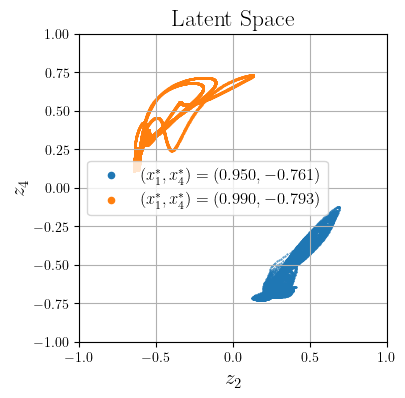

In [48]:
fig = plt.figure()
ax = fig.add_subplot(
#     projection='3d',
    aspect='equal'
)
# ax.view_init(
#     elev=30,
#     azim=-60,
# #     roll=15,
# )

begin_idx = 0
idx1 = 1
idx2 = 3
# idx3 = -7
for i in range(len(boundary_idx_arr_testing)):
    end_idx = boundary_idx_arr_testing[i]
    ax.scatter(
        latent_states_all_testingdata[begin_idx:end_idx, idx1].transpose(),
        latent_states_all_testingdata[begin_idx:end_idx, idx2].transpose(),
#         latent_states_all_testingdata[begin_idx:end_idx, idx3].transpose(),
        label=r"$(x_1^*, x_4^*) = ("+'{:.3f}, {:.3f}'.format(params_mat[i][0], params_mat[i][1])+r')$',
        s=0.2
    )
    begin_idx = boundary_idx_arr_testing[i]

ax.set_xlabel(r'$z_{'+str(1+idx1)+r'}$', fontsize=15)
ax.set_ylabel(r'$z_{'+str(1+idx2)+r'}$', fontsize=15)
# ax.set_zlabel(r'$z_{'+str(17+idx3)+r'}$', fontsize=15)

plt.legend(markerscale=10, fontsize=12, loc='center left')
plt.grid(True)

# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# # plt.zticks(fontsize=12)

plt.title(r'Latent Space', fontsize=17)
plt.gcf().set_size_inches(4,4)
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.savefig(dir_name_ae+'/plots/ls_separation.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()